In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## download the librairies : 
import matplotlib.pyplot as plt
import seaborn as sns

import math  

import warnings
warnings.filterwarnings("ignore")

In [3]:
## download the dataset : 

campaign_desc = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\campaign_desc.csv")
campaign_table = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\campaign_table.csv")
casual = pd.read_csv("D:\\Documents\\Qua môn\Datawarehouse&BI\extracted_files\\causal_data.csv")
coupon = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\coupon.csv")
coupon_redempt = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\coupon_redempt.csv")
hh_demographic = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\hh_demographic.csv")
product = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\product.csv")
transaction_data = pd.read_csv("D:\\Documents\\Qua môn\\Datawarehouse&BI\\extracted_files\\transaction_data.csv")

**Campaign_desc Table :** 

As we known from the campaign_desc table, this retailer had organized 30 campaigns during the time. We will have a look about their distribution. 

In [4]:
campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [5]:
## the time duration for each campaign : 
campaign_desc['DURATION'] = campaign_desc['END_DAY'] - campaign_desc['START_DAY']
print('The average time duration for a campaign is '+str(campaign_desc['DURATION'].mean())+' days.')

The average time duration for a campaign is 46.6 days.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


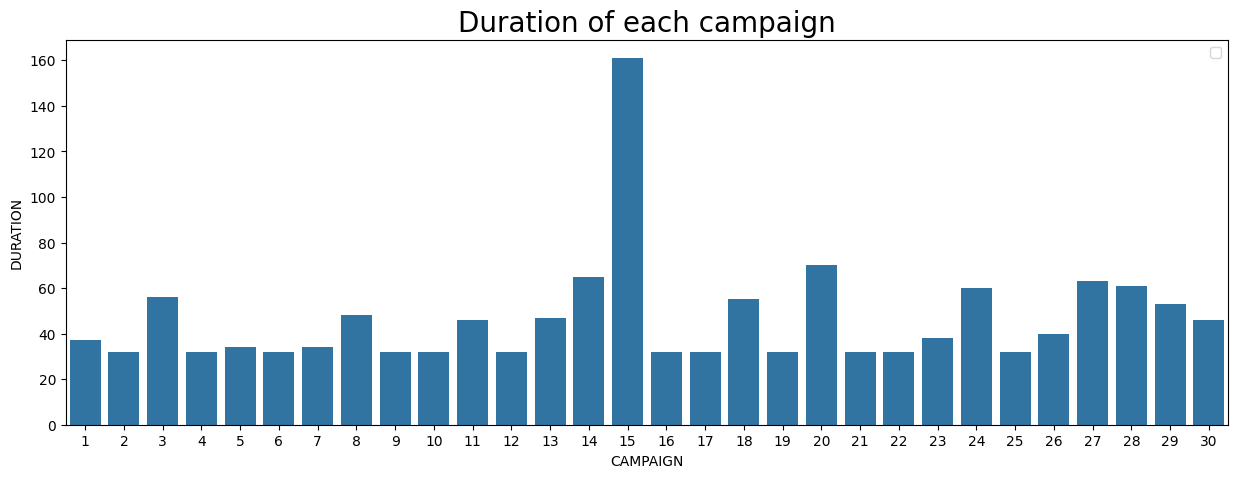

In [6]:
campaign_desc = campaign_desc.sort_values('CAMPAIGN')

plt.figure(figsize = (15,5))
sns.barplot(x='CAMPAIGN', y = 'DURATION', data = campaign_desc)
plt.title('Duration of each campaign', fontsize = 20)
plt.legend()

Campaign 15 lasted more than 160 days. The average campaign length is 46.6 days.

In [7]:
campaign_dist = campaign_desc.groupby('DESCRIPTION',as_index=False).agg(nb_campaign = ('CAMPAIGN', 'count'), avg_duration = ('DURATION','mean'))
campaign_dist

,DESCRIPTION,nb_campaign,avg_duration
0,TypeA,5,47.200000
1,TypeB,19,37.631579
2,TypeC,6,74.500000


There have been 19 type B campaigns, whose average length was 38 days. In comparison, there has been 6 type C campaigns of 75 days on average.

**campaign_table Table :**

In [8]:
campaign_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [9]:
print('There are '+str(campaign_table['household_key'].nunique())+' households have participed to the campaign, leaving '+str(2500-campaign_table['household_key'].nunique())+' households who never participated to any campaign.')


There are 1584 households have participed to the campaign, leaving 916 households who never participated to any campaign.


Text(0.5, 1.0, 'Nb of households by nb of campaigns they participated to')

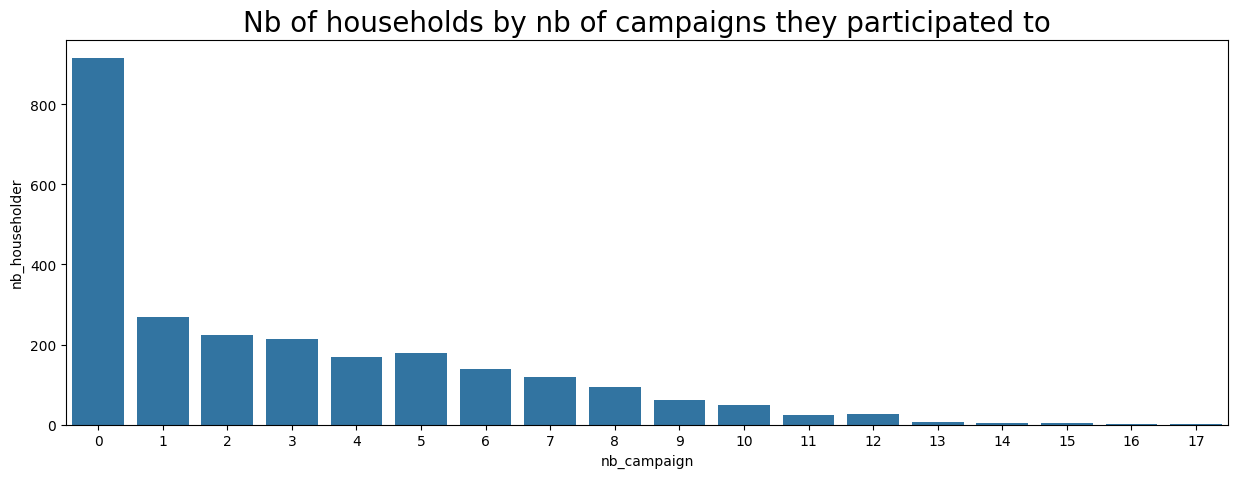

In [10]:
caipaign_per_hh = campaign_table.groupby('household_key',as_index=False).agg(nb_campaign = ('CAMPAIGN','count'))
nb_campaign = caipaign_per_hh.groupby('nb_campaign',as_index=False).agg(nb_householder = ('household_key','count'))

df = pd.DataFrame([[0, 916]], columns=['nb_campaign','nb_householder'])

nb_campaign = pd.concat([df, nb_campaign])
nb_campaign.reset_index(drop=True)

plt.figure(figsize = (15,5))
sns.barplot(x='nb_campaign', y = 'nb_householder', data = nb_campaign)
plt.title('Nb of households by nb of campaigns they participated to', fontsize = 20)

In [11]:
coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


In [12]:
## coupon composition : 
coupon.groupby('CAMPAIGN').agg(nb_coupon = ('COUPON_UPC','nunique'),nb_product = ('PRODUCT_ID','nunique')).sort_values('nb_product', ascending = False).head()

,nb_coupon,nb_product
CAMPAIGN,,
13,207,35616
18,209,35513
8,209,17178
26,181,3396
30,181,3205


Campaigns 13, 18 and 8 are the ones with most products in them. 

In [13]:
coupon_product = coupon.merge(right = product, on = 'PRODUCT_ID', how = 'left')

coupon_commodity_groupby = coupon_product.groupby('COMMODITY_DESC', as_index = False).agg(distinct_products = ('PRODUCT_ID', 'count'))
coupon_commodity_groupby.sort_values('distinct_products', ascending = False).head(10)

,COMMODITY_DESC,distinct_products
136,HAIR CARE PRODUCTS,6261
163,MAKEUP AND TREATMENT,5585
124,FRZN MEAT/MEAT DINNERS,4893
118,FROZEN PIZZA,3658
23,BEEF,3314
149,ICE CREAM/MILK/SHERBTS,3257
47,CHEESE,3146
265,YOGURT,2460
185,ORAL HYGIENE PRODUCTS,2437
161,LUNCHMEAT,2425


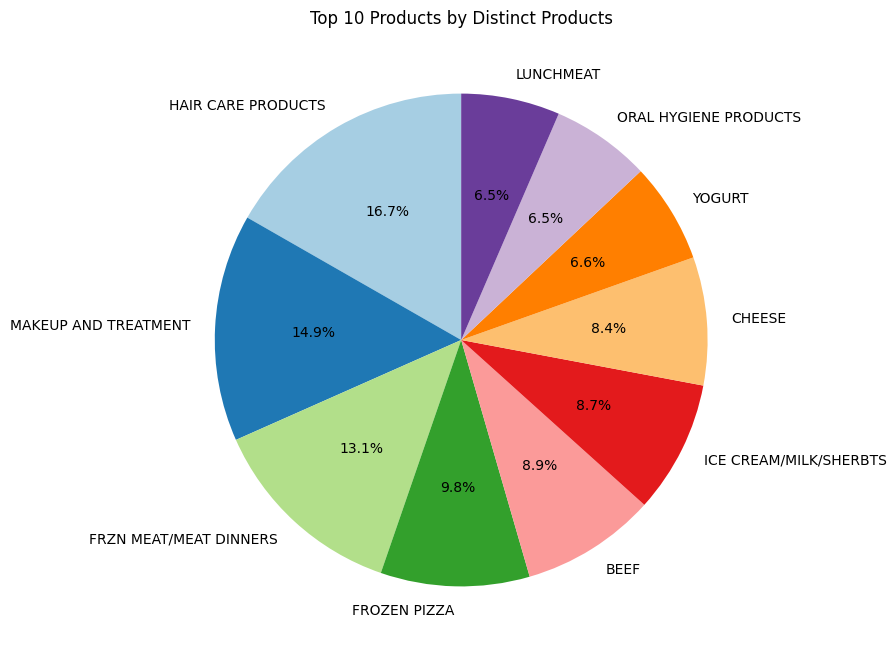

In [14]:
top_10_products = coupon_commodity_groupby.sort_values(by='distinct_products', ascending=False).head(10)

# Pie chart for top 10 products
plt.figure(figsize=(8, 8))
plt.pie(top_10_products['distinct_products'], labels=top_10_products['COMMODITY_DESC'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Adding title
plt.title('Top 10 Products by Distinct Products')

# Show the plot
plt.show()

Most prominent products among coupons created are bathroom products such as hair care and makeup.

**Transaction_data Table**

In [15]:
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [16]:
basket = transaction_data.groupby(['BASKET_ID'], as_index = False).agg(SALES_VALUE = ('SALES_VALUE', 'sum'),COUPON_DISC = ('COUPON_DISC', 'sum'),COUPON_MATCH_DISC = ('COUPON_MATCH_DISC', 'sum') )
basket['Use_coupon'] = basket['COUPON_DISC'] != 0

basket.head()

,BASKET_ID,SALES_VALUE,COUPON_DISC,COUPON_MATCH_DISC,Use_coupon
0,26984851472,5.91,0.0,0.0,False
1,26984851516,12.43,0.0,0.0,False
2,26984896261,11.37,0.0,0.0,False
3,26984905972,2.55,0.0,0.0,False
4,26984945254,3.53,0.0,0.0,False


In [17]:
round(basket['SALES_VALUE'].mean(),2)
print('The average basket value is $'+str(round(basket['SALES_VALUE'].mean(),2))+'.')

The average basket value is $29.14.


Text(0.5, 1.0, 'Basket value boxplot')

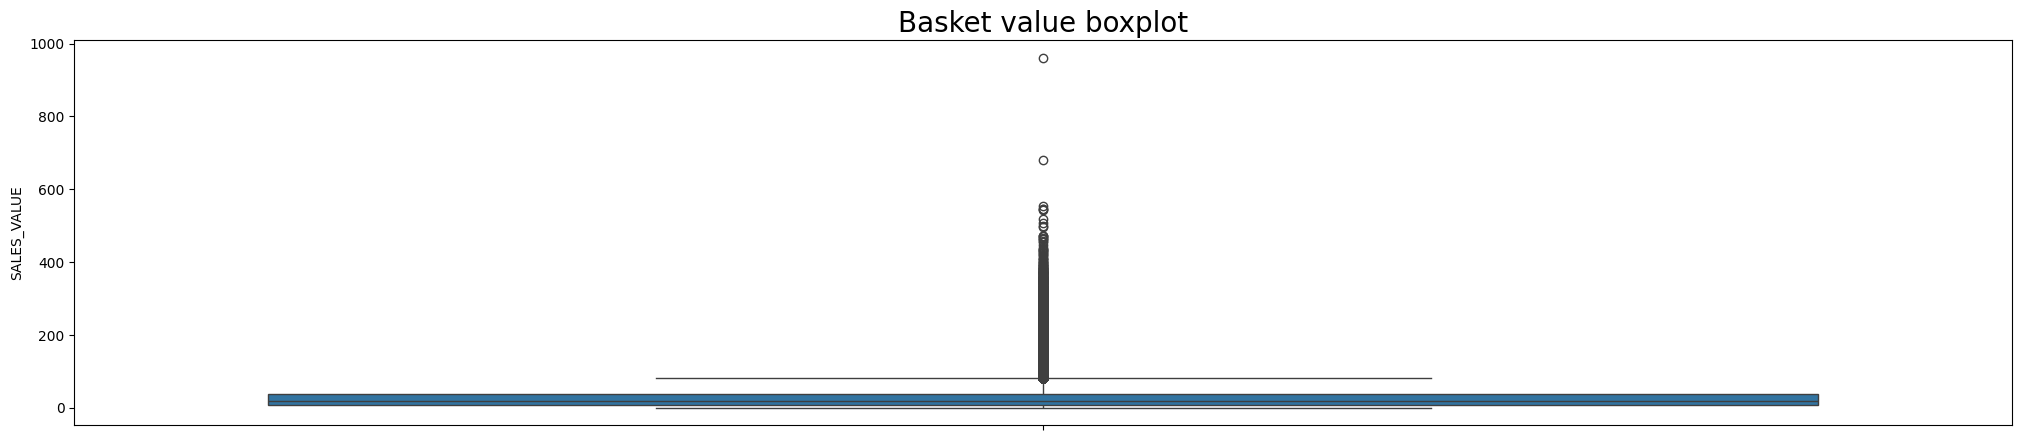

In [18]:
plt.figure(figsize = (25,5))
ax = sns.boxplot( basket['SALES_VALUE'])
plt.title('Basket value boxplot', fontsize = 20)

In [19]:
### panier moyen avec/sans coupon : 
Use_coupon = basket.groupby(['Use_coupon'], as_index = False).agg(SALES_MEAN = ('SALES_VALUE', 'mean')
                                                     ,COUPON_DISC_MEAN = ('COUPON_DISC', 'mean')
                                                     ,COUPON_MATCH_DISC_MEAN = ('COUPON_MATCH_DISC', 'mean')
                                                     ,Nb_coupon = ('SALES_VALUE', 'count'))

Use_coupon['%_coupon'] = round((Use_coupon['Nb_coupon']/(Use_coupon['Nb_coupon'].sum()))*100,2)
Use_coupon

,Use_coupon,SALES_MEAN,COUPON_DISC_MEAN,COUPON_MATCH_DISC_MEAN,Nb_coupon,%_coupon
0,False,26.664947,0.000000,0.00000,259733,93.94
1,True,67.559937,-2.543821,-0.45226,16751,6.06


The average basket value without a coupon is $26.7.

The average basket value with a coupon is $67.6.

The average discount generated by coupons is $2.5.

A $1 coupon generates an additional basket value of $16.

In [20]:
basket['cut'] = pd.qcut(basket['SALES_VALUE'], 4)

basket_cut = basket.groupby(['cut'], as_index = False).agg(Use_coupon = ('Use_coupon', 'sum'), nb_basket = ('SALES_VALUE', 'count'))

basket_cut['%_use_coupon'] = round((basket_cut['Use_coupon']/basket_cut['nb_basket'])*100,2)
basket_cut

,cut,Use_coupon,nb_basket,%_use_coupon
0,"(-0.001, 6.96]",792,69170,1.15
1,"(6.96, 17.07]",1971,69097,2.85
2,"(17.07, 36.28]",3297,69111,4.77
3,"(36.28, 961.49]",10691,69106,15.47


The more expensive the basket, the likelier the customer is to use a coupon.

In [21]:
basket_coupon = basket[basket['Use_coupon']==True]

coupon_cut = basket_coupon.groupby(['cut'], as_index = False).agg(SALES_VALUE = ('SALES_VALUE', 'mean'), 
                                                                  coupon_value = ('COUPON_DISC', 'mean'), 
                                                                  nb_coupon = ('COUPON_DISC', 'count'))

sum_nb_coupon = coupon_cut['nb_coupon'].sum()

coupon_cut['%_disc'] = round(((coupon_cut['coupon_value']/coupon_cut['SALES_VALUE'])*100),2)
coupon_cut['%_nb_coupon'] = round(((coupon_cut['nb_coupon']/sum_nb_coupon)*100),2)

coupon_cut

,cut,SALES_VALUE,coupon_value,nb_coupon,%_disc,%_nb_coupon
0,"(-0.001, 6.96]",4.008624,-1.203737,792,-30.03,4.73
1,"(6.96, 17.07]",12.127220,-1.677900,1971,-13.84,11.77
2,"(17.07, 36.28]",26.400834,-1.930355,3297,-7.31,19.68
3,"(36.28, 961.49]",95.180560,-2.991924,10691,-3.14,63.82


Among baskets with coupons, the most prominent are the high value ones.

In [22]:
transaction_bis = transaction_data.merge(right = basket[['BASKET_ID','Use_coupon']], on = 'BASKET_ID', how = 'left') 
transaction_bis['product_value'] = transaction_bis['SALES_VALUE']/transaction_bis['QUANTITY']
transaction_bis =  transaction_bis.merge(right = product, on = 'PRODUCT_ID', how = 'left') 

In [23]:
COMMODITY_coupon = transaction_bis.groupby(['COMMODITY_DESC'], as_index = False).agg(Qt_total= ('QUANTITY', 'count'),Use_coupon = ('Use_coupon', 'sum'), COUPON = ('COUPON_DISC', 'sum'))
COMMODITY_coupon['%_Coupon'] = round(((COMMODITY_coupon['Use_coupon']/COMMODITY_coupon['Qt_total'])*100),2)
COMMODITY_coupon = COMMODITY_coupon.sort_values('COUPON', ascending = True)
COMMODITY_coupon.head(11)

,COMMODITY_DESC,Qt_total,Use_coupon,COUPON,%_Coupon
0,,7839,6198,-10306.04,79.07
273,SOFT DRINKS,117532,13685,-3653.98,11.64
58,CIGARETTES,12319,1060,-1454.67,8.60
85,DIAPERS & DISPOSABLES,5008,1226,-1021.82,24.48
3,AIR CARE,5556,1364,-910.04,24.55
67,COLD CEREAL,37870,6466,-848.28,17.07
243,REFRGRATD DOUGH PRODUCTS,18960,4202,-821.73,22.16
140,FRZN MEAT/MEAT DINNERS,56064,10222,-790.54,18.23
134,FROZEN PIZZA,43362,7394,-783.84,17.05
91,DOG FOODS,12093,2437,-732.33,20.15


While the most prominents products for which coupons are created are haircare and makeup products, coupons are mostly used on drinks, cigarettes, diapers, etc. Bathroom products are not even among the top 10

In [24]:
## group transaction_data table by 'household_key', 'week_no' and ('day')
hh_week = transaction_data.groupby(['household_key','WEEK_NO','DAY'], as_index = False).agg(SALES_VALUE = ('SALES_VALUE', 'sum'),RETAIL_DISC = ('RETAIL_DISC', 'sum'),COUPON_DISC = ('COUPON_DISC', 'sum'),COUPON_nb = ('COUPON_DISC', 'count') )

In [25]:
hh_Per_week = hh_week.groupby(['WEEK_NO'], as_index = False).agg(nb_hh = ('household_key', 'nunique'), 
                                                                 SALES_VALUE = ('SALES_VALUE', 'sum'),
                                                                 RETAIL_DISC = ('RETAIL_DISC', 'sum'), 
                                                                 COUPON_DISC = ('COUPON_DISC', 'sum'),
                                                                 COUPON_nb = ('COUPON_nb', 'sum'))

hh_Per_week['SALES_per_HH'] = round(hh_Per_week['SALES_VALUE']/hh_Per_week['nb_hh'],2)
hh_Per_week['RDisc_per_HH'] = -(round(hh_Per_week['RETAIL_DISC']/hh_Per_week['nb_hh'],2))
hh_Per_week['CDisc_per_HH'] = -(round(hh_Per_week['COUPON_DISC']/hh_Per_week['nb_hh'],2))
hh_Per_week.head()

,WEEK_NO,nb_hh,SALES_VALUE,RETAIL_DISC,COUPON_DISC,COUPON_nb,SALES_per_HH,RDisc_per_HH,CDisc_per_HH
0,1,88,5211.16,-1037.25,-16.74,1881,59.22,11.79,0.19
1,2,175,10821.35,-2147.61,-21.58,3675,61.84,12.27,0.12
2,3,228,13498.20,-2548.16,-78.62,4803,59.20,11.18,0.34
3,4,270,15965.99,-2883.95,-77.99,5379,59.13,10.68,0.29
4,5,370,20139.82,-3962.06,-83.36,7168,54.43,10.71,0.23


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


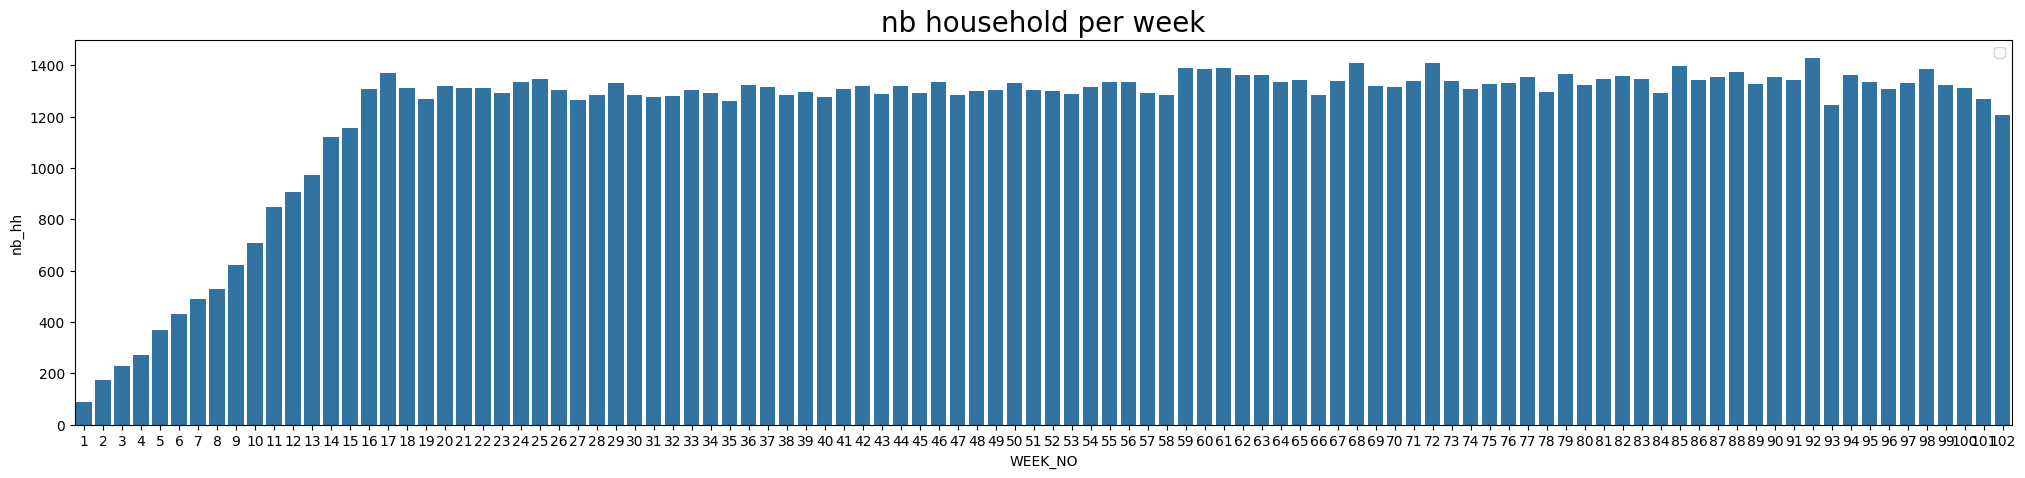

In [26]:
plt.figure(figsize = (25,5))
sns.barplot(x='WEEK_NO', y = 'nb_hh', data = hh_Per_week)
plt.title('nb household per week', fontsize = 20)
plt.legend()

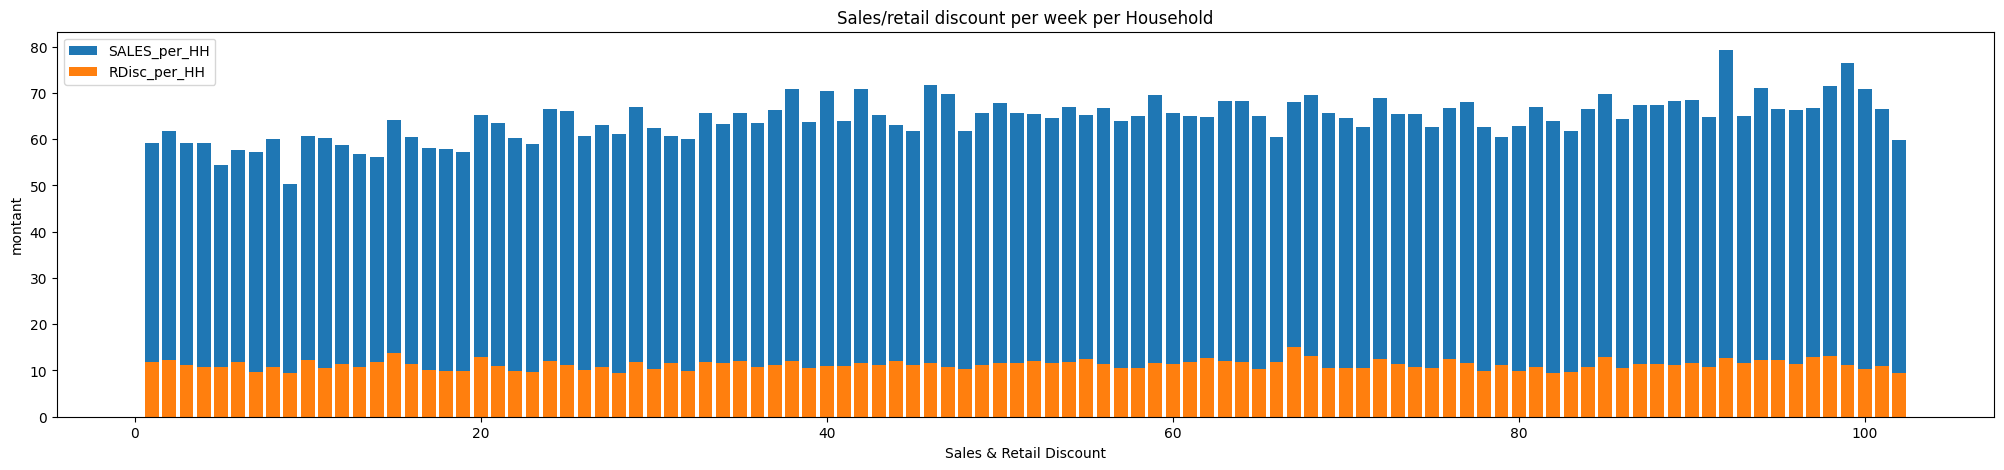

In [27]:
plt.figure(figsize = (25,5))

plt.title("Sales/retail discount per week per Household")
plt.bar(hh_Per_week['WEEK_NO'], hh_Per_week['SALES_per_HH'], label = "SALES_per_HH")
plt.bar(hh_Per_week['WEEK_NO'], hh_Per_week['RDisc_per_HH'] ,label = 'RDisc_per_HH')
plt.xlabel("Sales & Retail Discount")
plt.ylabel("montant")
plt.legend();

In [28]:
hh_frequency = hh_week.groupby('household_key').agg(DAY_max = ('DAY','max'),DAY_min = ('DAY','min'),DAY_count = ('DAY','count'))

hh_frequency['frequency'] = round((hh_frequency['DAY_max']- hh_frequency['DAY_min'])/hh_frequency['DAY_count'],1)
print('Thhe average days that the household do their shooping is '+str(round(hh_frequency['frequency'].mean(),1))+' days. The median is '+ str(round(hh_frequency['frequency'].median(),1)) + ' days.')

Thhe average days that the household do their shooping is 15.5 days. The median is 9.0 days.


Text(0.5, 1.0, 'Household shopping frequency')

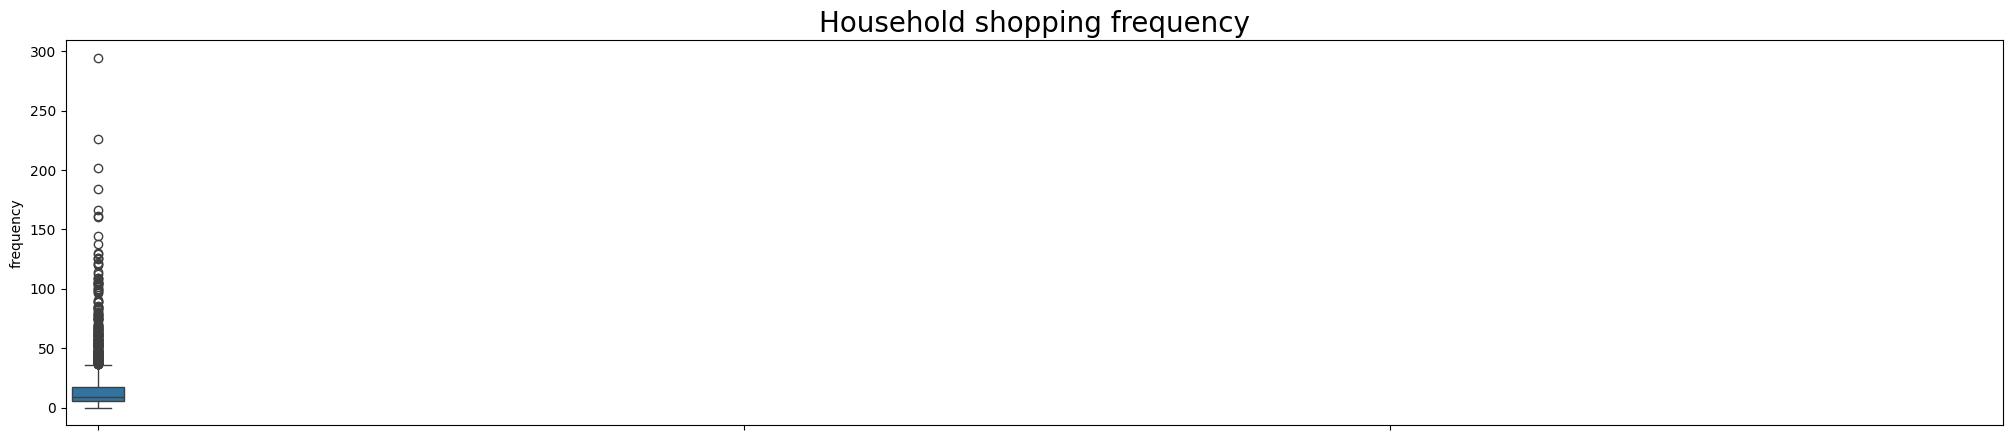

In [29]:
plt.figure(figsize = (25,5))
plt.xticks(np.arange(0, 300, step=10))
ax = sns.boxplot(hh_frequency['frequency'])
plt.title('Household shopping frequency', fontsize = 20)

As on average shopping sessions are more than two weeks appart, we will be using a 3-week-long time unit for the next analyisis.

In [30]:
### on décide si un household n'est pas active pendant 3 semaines

hh_week['weekBy3'] = hh_week['WEEK_NO'].apply(lambda x : math.ceil(x/3))

hh_3week = hh_week.groupby(['household_key','weekBy3'], as_index = False).agg(SALES_VALUE = ('SALES_VALUE', 'sum'),RETAIL_DISC = ('RETAIL_DISC', 'sum'),COUPON_DISC = ('COUPON_DISC', 'sum') )

frist_week = hh_3week.groupby('household_key', as_index = False).agg(frist_week = ('weekBy3', 'min'))
hh_3week = hh_3week.merge(frist_week, on = 'household_key', how = 'left')

hh_3week.head()

,household_key,weekBy3,SALES_VALUE,RETAIL_DISC,COUPON_DISC,frist_week
0,1,3,78.66,-16.54,-1.00,3
1,1,4,41.10,-8.59,0.00,3
2,1,5,143.78,-34.22,-1.50,3
3,1,6,50.31,-11.21,0.00,3
4,1,7,197.78,-26.82,-2.25,3


In [31]:
df = pd.DataFrame({'returning': [], 'df_loss': [], 'reactived': [], 'new': []})
i = 1

while i < 35 : 
    df_returning = hh_3week[hh_3week['weekBy3']==i-1][['household_key','frist_week']].merge(hh_3week[hh_3week['weekBy3']==i][['household_key','frist_week']],on = 'household_key', how = 'inner')
    df_left = hh_3week[hh_3week['weekBy3']==i-1][['household_key','frist_week']].merge(hh_3week[hh_3week['weekBy3']==i][['household_key','frist_week']],on = 'household_key', how = 'left')
    df_loss = df_left[df_left['frist_week_y'].isna()]
    df_right = hh_3week[hh_3week['weekBy3']==i-1][['household_key','frist_week']].merge(hh_3week[hh_3week['weekBy3']==i][['household_key','frist_week']],on = 'household_key', how = 'right')
    df_new = df_right[df_right['frist_week_x'].isna()]
    df_truly_new = df_new[df_new['frist_week_y']>=i]
    df_reactied = df_new[df_new['frist_week_y']<i]

    df = df.append({'returning': len(df_returning), 'df_loss': len(df_loss), 'reactived': len(df_reactied), 'new':  len(df_truly_new)}, ignore_index=True)
    i += 1

df['loss'] = - df['df_loss']
df['new_hh'] = df['returning']+df['reactived']+df['new']
df['reactived_hh'] = df['returning']+df['reactived']

df = df[['new_hh','reactived_hh','returning','loss']]

AttributeError: 'DataFrame' object has no attribute 'append'

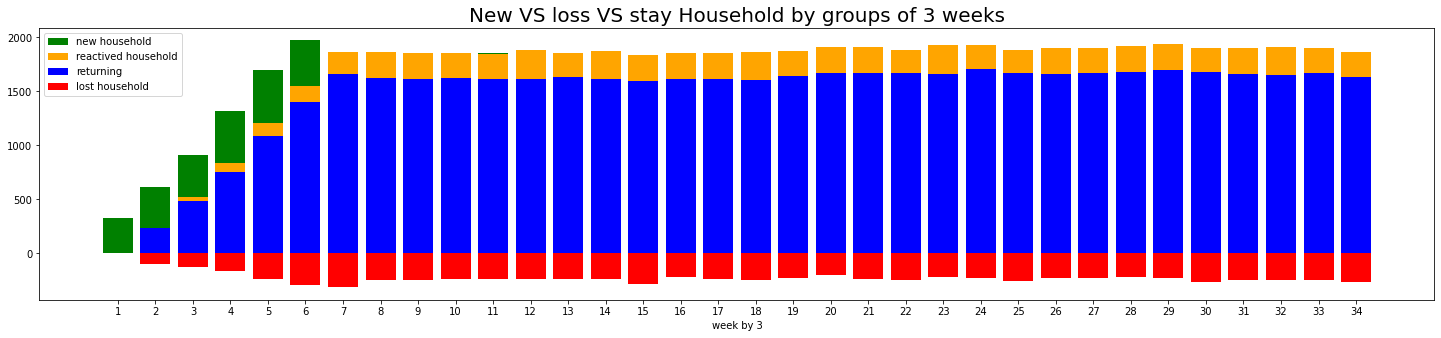

In [ ]:
plt.figure(figsize = (25,5))

plt.title("New VS loss VS stay Household by groups of 3 weeks",fontsize = 20)
plt.xticks(np.arange(1, 35, step=1))
plt.bar(range(1,35,1), df['new_hh'], color = 'green',label = "new household")
plt.bar(range(1,35,1), df['reactived_hh'] ,color = 'orange',label = 'reactived household')
plt.bar(range(1,35,1), df['returning'],color = 'blue',label = 'returning')
plt.bar(range(1,35,1), df['loss'],color = 'red',label = 'lost household')
plt.xlabel("week by 3")
plt.ylabel("")
plt.legend();

**Household demographic analysis :**

In [ ]:
def pie_categorical(data):
    #function to plot the histogram of categorical variables in pie graph
    features = data.columns
    #plot pie charts of categorical variables
    fig_pie_cat = plt.figure(figsize=(15,15))
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_pie_cat.add_subplot(rows,cols,count)
        data[i].value_counts().plot(kind="pie",autopct="%.1f%%",ax=ax)
        plt.ylabel("")
        plt.title(i,fontweight="bold",fontsize=8)
        count += 1

def hist_numeric(data):
    #function to plot the histogram of numeric variables
    features = data.columns
    fig_hists = plt.figure(figsize=(15,15))
    fig_hists.subplots_adjust(hspace=0.5,wspace=0.5)
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_hists.add_subplot(rows,cols,count)
        data[i].plot(kind="hist",alpha=.5,bins=25,edgecolor="navy",legend=False,ax=ax)
        ax.set_xlabel("")
        ax.set_title(i,fontweight="bold",fontsize=10)
        count += 1

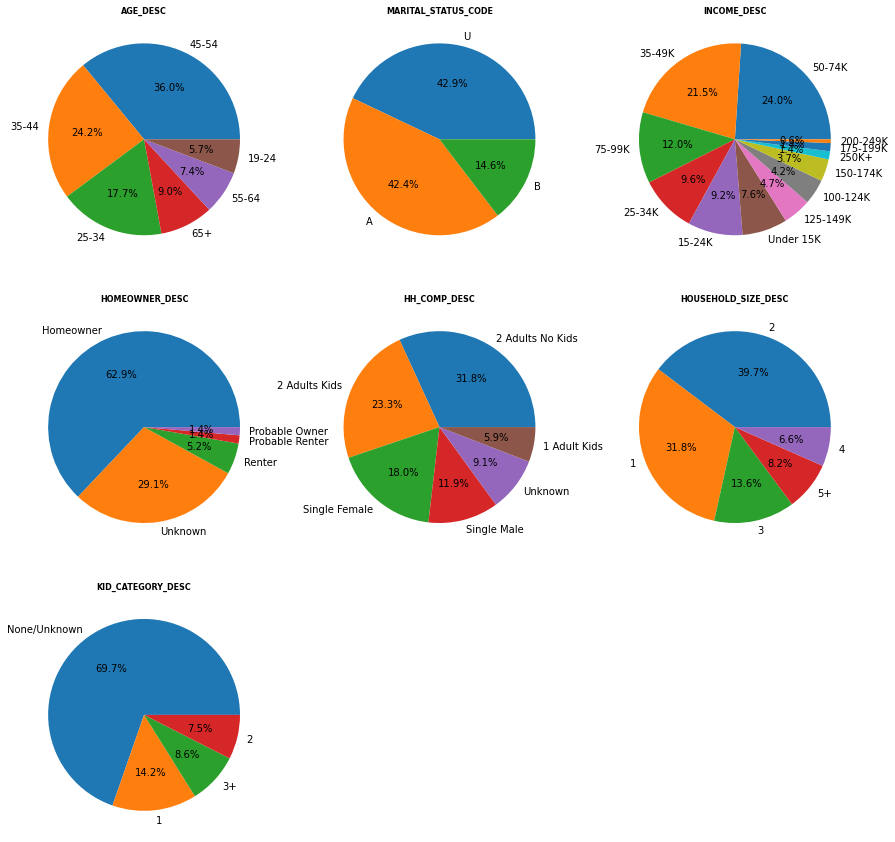

In [ ]:
pie_categorical(hh_demographic.drop("household_key",axis=1))

In [ ]:
## household groupby day
hh_day = transaction_data.groupby(['household_key','DAY'],as_index = False).agg(SALES_VALUE = ('SALES_VALUE', 'sum'),RETAIL_DISC = ('RETAIL_DISC', 'sum'),COUPON_DISC = ('COUPON_DISC', 'sum'),DAY_MAX = ('DAY','max'),DAY_MIN = ('DAY','min'))

## groupby household
hh_table = hh_day.groupby('household_key',as_index = False).agg(SALES_VALUE = ('SALES_VALUE', 'sum'),RETAIL_DISC = ('RETAIL_DISC', 'sum'),COUPON_DISC = ('COUPON_DISC', 'sum'),DAY_nb = ('DAY','count'),DAY_MAX = ('DAY','max'),DAY_MIN = ('DAY','min'))
hh_table['SALES_VALUE_day'] = round(hh_table['SALES_VALUE']/hh_table['DAY_nb'],2)
hh_table['RETAIL_DISC_day'] = round(hh_table['RETAIL_DISC']/hh_table['DAY_nb'],2)
hh_table['COUPON_DISC_day'] = round(hh_table['COUPON_DISC']/hh_table['DAY_nb'],2)
hh_table['frequency'] = round(((hh_table['DAY_MAX']-hh_table['DAY_MIN'])/hh_table['DAY_nb']),1)
hh_table['Use_coupon'] = hh_table['COUPON_DISC'] != 0

count_coupon = transaction_data[transaction_data['COUPON_DISC'] != 0]
hh_coupon = count_coupon.groupby('household_key',as_index = False).agg(nb_coupon = ('COUPON_DISC', 'count'))

hh_table = hh_table.merge(hh_coupon, on = 'household_key', how = 'left')

hh_table = hh_table[['household_key','DAY_nb','frequency','SALES_VALUE_day','RETAIL_DISC_day','nb_coupon','COUPON_DISC_day','Use_coupon']]
hh_table['nb_coupon'] = hh_table['nb_coupon'].fillna(0)

hh_demographic_table = hh_demographic.merge(hh_table, on = 'household_key', how = 'left')
hh_demographic_table.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,DAY_nb,frequency,SALES_VALUE_day,RETAIL_DISC_day,nb_coupon,COUPON_DISC_day,Use_coupon
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,79,8.3,54.81,-8.82,106.0,-1.02,True
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,59,11.6,57.63,-8.18,27.0,-0.52,True
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,103,6.2,53.74,-10.47,24.0,-0.28,True
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,203,3.0,64.98,-8.02,300.0,-1.52,True
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,90,6.6,16.80,-1.90,1.0,-0.01,True


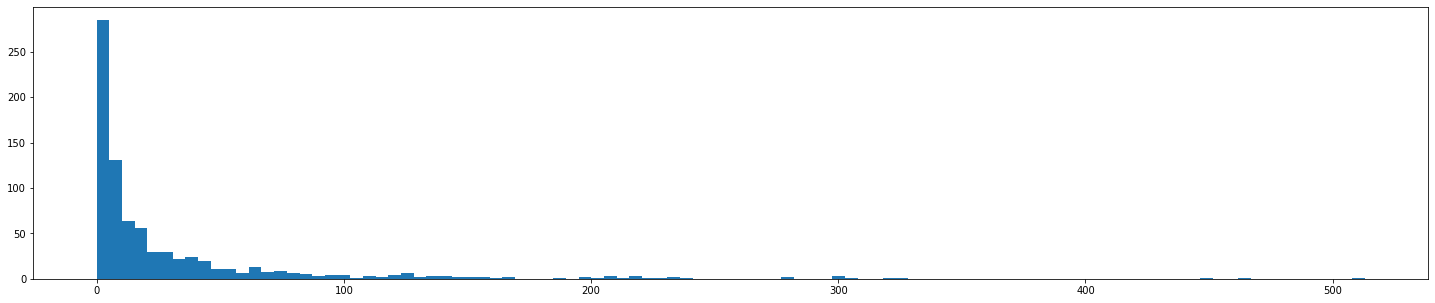

In [ ]:
plt.figure(figsize = (25,5))

hist = plt.hist(hh_demographic_table['nb_coupon'],bins = 100)
#plt.title('Household shopping frequency', fontsize = 20)